## Impact of TOP/Sub-orbital Total Electron Content (TEC) on SAR range delay

Dataset: Chile Sen asc track 149

+ Figure 1. Residual RMSE of (SAR - TECgim - SET - ERA5) vs. (SAR - TECsub - SET - ERA5)
+ Figure 2. Time-series of GIM/SUB/TOP_TEC and its predicted range delay for X/C/S/L-band SAR

In [2]:
%matplotlib inline
import os
import h5py
import numpy as np
import datetime as dt
from matplotlib import pyplot as plt, ticker

from mintpy.objects import timeseries
from mintpy.utils import ptime, readfile, utils as ut, plot as pp
from tools.simulation import iono
from tools import iono_tec
plt.rcParams.update({'font.size': 12})
figsize = [9, 3]

# config
n = 3                                 # number of med abs dev
dt_s1ab = dt.datetime(2016, 10, 7)    # dateime separating S1A and S1B
dt2 = dt.datetime(2017, 9, 1)
save = True

# location of interest
win = 9  # size of the window of interest where the median offset is calculated
lalo = [-21.29, -69.58]; box_suffix = 'boxCL'   # box in the center left with low  altitude; box = (10,  55,  20, 70) for SenAT149
lalo = [-21.30, -67.39]; box_suffix = 'boxLR'   # box in the lower right with high altitude; box = (200, 15, 215, 30) for SenAT149

# dir
proj_dir = os.path.expanduser('~/data/geolocation/ChileSenAT149')
proj_name = os.path.basename(proj_dir)

work_dir = os.path.join(proj_dir, 'offset_comp')
if box_suffix is not None:
    work_dir = os.path.join(work_dir, box_suffix)
os.chdir(work_dir)
print('Go to directory', work_dir)

# matplotlib setup
plt.rcParams.update({'font.size': 12})
plt.rcParams.update({'lines.linewidth': 3.0})

Go to directory /Users/yunjunz/data/geolocation/ChileSenAT149/offset_comp/boxLR


## Figure - TS residual: gimTEC vs. subTEC

### 1. Generate HDF5/MintPy files

In [6]:
os.chdir(os.path.join(proj_dir, 'mintpy_offset'));  print('Go to directory:', os.path.join(proj_dir, 'mintpy_offset'))

# residual TS with gimTEC
!add.py  timeseriesRg.h5            inputs/gimTEC.h5 -o timeseriesRg_gimTEC.h5
!reference_date.py timeseriesRg_gimTEC.h5 -t ChileSenAT149.txt --force
!diff.py timeseriesRg_gimTEC.h5     inputs/SET.h5    -o timeseriesRg_gimTEC_SET.h5
!diff.py timeseriesRg_gimTEC_SET.h5 inputs/ERA5.h5   -o timeseriesRg_gimTEC_SET_ERA5.h5

# residual TS with subTEC
!add.py  timeseriesRg.h5            inputs/subTEC.h5 -o timeseriesRg_subTEC.h5
!reference_date.py timeseriesRg_subTEC.h5 -t ChileSenAT149.txt --force
!diff.py timeseriesRg_subTEC.h5     inputs/SET.h5    -o timeseriesRg_subTEC_SET.h5
!diff.py timeseriesRg_subTEC_SET.h5 inputs/ERA5.h5   -o timeseriesRg_subTEC_SET_ERA5.h5

os.chdir(work_dir);  print('Go to directory:', work_dir)

Go to directory: /Users/yunjunz/data/geolocation/ChileSenAT149/mintpy_offset
setenv: Variable name must contain alphanumeric characters.
input files to be added: (2)
['timeseriesRg.h5', 'inputs/gimTEC.h5']
adding timeseries ...
use metadata from the 1st file: timeseriesRg.h5
delete exsited file: timeseriesRg_gimTEC.h5
create HDF5 file: timeseriesRg_gimTEC.h5 with w mode
create dataset /timeseries of float32    in size of (104, 123, 231)      with compression=None
create dataset /bperp      of float32    in size of (104,)     with compression=None
create dataset /date       of |S8        in size of (104,)     with compression=None
finished writing to timeseriesRg_gimTEC.h5
Done.
setenv: Variable name must contain alphanumeric characters.
input reference date: 20200123
--------------------------------------------------
change reference date for file: /Users/yunjunz/data/geolocation/ChileSenAT149/mintpy_offset/timeseriesRg_gimTEC.h5
reading data ...
referencing in time ...
---------------

### 2. Read & Plot

/Users/yunjunz/tools/miniconda3/envs/insar/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)


save figure to file /Users/yunjunz/data/geolocation/ChileSenAT149/offset_comp/boxLR/TS_res_subTEC_vs_gimTEC.png


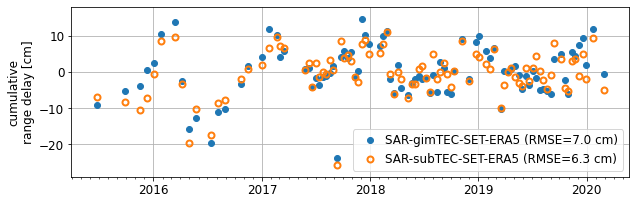

In [90]:
### Read data

ts_file1 = os.path.join(proj_dir, 'mintpy_offset/timeseriesRg_gimTEC_SET_ERA5.h5')
ts_file2 = os.path.join(proj_dir, 'mintpy_offset/timeseriesRg_subTEC_SET_ERA5.h5')

# date info
date_list = timeseries(sar_file).get_date_list()
dates = np.array(ptime.date_list2vector(date_list)[0])
num_date = len(date_list)

# lalo --> box
atr = readfile.read_attribute(sar_file)
coord = ut.coordinate(atr, lookup_file=geom_file)
y, x = coord.geo2radar(lalo[0], lalo[1])[:2]
win2 = int(win/2)
box = (x-win, y-win, x+win+1, y+win+1)

# read
ts1 = np.nanmedian(readfile.read(ts_file1, box=box)[0].reshape(num_date, -1), axis=-1) * 100.
ts2 = np.nanmedian(readfile.read(ts_file2, box=box)[0].reshape(num_date, -1), axis=-1) * 100.

# omit dates without GIM/SUB_TEC
sub_tec_file = os.path.join(proj_dir, 'mintpy_offset/inputs/subTEC.h5')
ts_tec = np.nanmedian(readfile.read(sub_tec_file, box=box)[0].reshape(num_date, -1), axis=-1)

flag = ~np.isnan(ts_tec)
dates = dates[flag]
ts1 = ts1[flag];  ts1 -= np.nanmedian(ts1)
ts2 = ts2[flag];  ts2 -= np.nanmedian(ts2)
rmse1 = ut.root_mean_sq_error(ts1)
rmse2 = ut.root_mean_sq_error(ts2)


### plot

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[9, 3])
# bar plot
#xstep = np.min(np.diff(dates)) / 2 * (5/6)
#ax.bar(dates - xstep/2, ts1, width=xstep, label='SAR-gimTEC-SET-ERA5 (RMSE={:.1f} cm)'.format(rmse1))
#ax.bar(dates + xstep/2, ts2, width=xstep, label='SAR-subTEC-SET-ERA5 (RMSE={:.1f} cm)'.format(rmse2))
# dot plot
ax.plot(dates, ts1, 'o', mew=1, mfc='C0',   label='SAR-gimTEC-SET-ERA5 (RMSE={:.1f} cm)'.format(rmse1))
ax.plot(dates, ts2, 'o', mew=2, mfc='none', label='SAR-subTEC-SET-ERA5 (RMSE={:.1f} cm)'.format(rmse2))

# axis format
pp.auto_adjust_xaxis_date(ax, dates, every_year=1, buffer_year=None)
ax.set_ylabel('cumulative\nrange delay [cm]')
ax.set_ylim(-29, 18)
ax.legend(loc='lower right', handletextpad=0.3)
ax.grid('on')
fig.tight_layout()

# output
out_fig = os.path.join(work_dir, 'TS_res_subTEC_vs_gimTEC.png')
print('save figure to file', out_fig)
plt.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=300)
plt.show()

## Figure - Impact of ionosphere on C-/S-/L-band SAR

### 1. Read data

In [3]:
geom_file = os.path.join(proj_dir, 'mintpy_offset/inputs/geometryRadar.h5')
tec_file  = os.path.join(proj_dir, 'mintpy_offset/inputs/subTEC.h5')

# geometry
(iono_inc_angle,
 iono_lat,
 iono_lon,
 iono_height) = iono.prep_geometry_iono_shell_along_los(geom_file)
iono_inc_angle = np.nanmedian(iono_inc_angle)

# TEC
tec_dict = {}
with h5py.File(tec_file, 'r') as f:
    tec_dict['topTEC'] = f['vtec_top'][:]
    tec_dict['subTEC'] = f['vtec_sub'][:]
    tec_dict['gimTEC'] = f['vtec_gim'][:]

# time
date_list = timeseries(tec_file).get_date_list()
dates = ptime.date_list2vector(date_list)[0]

incidence angle on the ground     min/max: 30.0/46.1 deg
incidence angle on the ionosphere min/max: 27.9/42.3 deg
center lat/lon  on the ground    : -21.0438/-68.4108 deg
center lat/lon  on the ionosphere: -18.1416/-69.1286 deg


/Users/yunjunz/tools/dev/tools/simulation/iono.py:121: RuntimeWarning: invalid value encountered in sin
  cos_inc_angle_iono = np.sqrt(1 - (EARTH_RADIUS * np.sin(inc_angle) / (EARTH_RADIUS + iono_height))**2)


### 2. Plot

save figure to file /Users/yunjunz/data/geolocation/ChileSenAT149/offset_comp/TECgim_pred.png


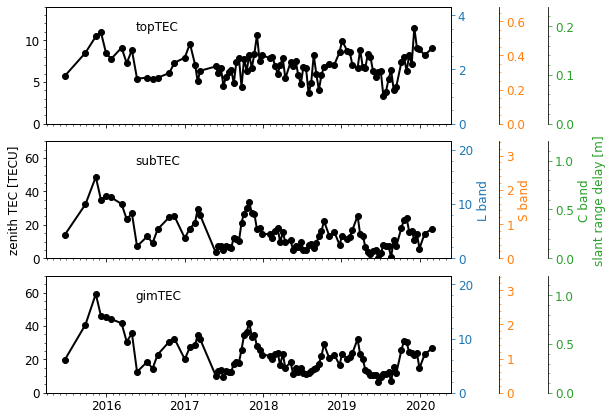

In [3]:
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=[9, 6], sharex=True)
for i, (ax, tec_type, ymax, ystep) in enumerate(zip(axs, tec_dict.keys(), [14, 70, 70], [1, 5, 5])):
    ts_tec = tec_dict[tec_type]
    # omit nan values
    flag = ~np.isnan(ts_tec)
    ts_tec = np.array(ts_tec)[flag]
    x = np.array(dates)[flag]

    # plot
    ax.plot(x, ts_tec, '-o', label=tec_type, color='k', ms=6, lw=2)
    ax.set_ylim(0, ymax)
    ax.yaxis.set_minor_locator(ticker.MultipleLocator(ystep))
    ax.annotate(tec_type, xy=(0.22, 0.8), xycoords='axes fraction', color='k', ha='left')

    # predicted range delay
    for j, (bname, c) in enumerate(zip(iono.SAR_BAND.keys(), ['C0', 'C1', 'C2'])):
        # calculate
        ts_delay = iono.vtec2range_delay(ts_tec,
                                         inc_angle=iono_inc_angle,
                                         freq=iono.SAR_BAND[bname])

        # add y-axis
        ax2 = ax.twinx()
        ax2.spines['right'].set_position(('axes', 1.0+0.12*j))
        ax2.tick_params(which='both', axis='y', colors=c)
        ax2.yaxis.set_minor_locator(ticker.AutoMinorLocator())

        # ylabel
        if i == 1:
            label = '{} band'.format(bname)
            if j == 2:
                label += '\nslant range delay [m]'
            ax2.set_ylabel(label, color=c)

        # ylim sync btw. ax and ax2
        ratio = ((np.max(ts_delay) - np.min(ts_delay)) / (np.max(ts_tec)   - np.min(ts_tec)))
        ax2.set_ylim(np.array(ax.get_ylim()) * ratio)
        ## test
        #ax2.plot(x, ts_delay, 'o', mfc='none')

# axis format
pp.auto_adjust_xaxis_date(ax, dates, every_year=1, buffer_year=None)
axs[1].set_ylabel('zenith TEC [TECU]')
fig.tight_layout()
fig.subplots_adjust(hspace=0.15)

# output
out_fig = os.path.join(proj_dir, 'offset_comp/TECgim_pred.png')
print('save figure to file', out_fig)
#plt.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=300)
plt.show()

## Figure - Percentage of TOP TEC

save figure to file /Users/yunjunz/data/geolocation/ChileSenAT149/offset_comp/TECtop_perc.png


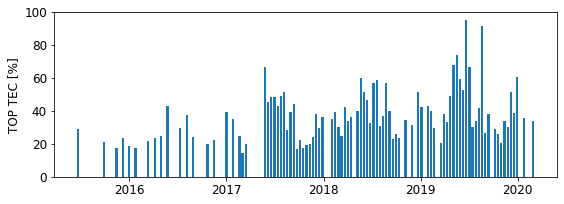

In [15]:
xwid = np.min(np.diff(dates)) * 0.7
fig, ax = plt.subplots(figsize=[8, 3])
ax.bar(dates, tec_dict['topTEC']/tec_dict['gimTEC'] * 100, width=xwid)
ax.set_ylabel('TOP TEC [%]')
ax.set_ylim(0, 100)
fig.tight_layout()

# output
out_fig = os.path.join(proj_dir, 'offset_comp/TECtop_perc.png')
print('save figure to file', out_fig)
plt.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=300)
plt.show()